# Explainability

**Analyse our model behavior**

## 0. Requirements

### 0.0 install and import dependancies


In [1]:
%pip install xgboost==1.6 shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 MB 5.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.5.0
    Uninstalling xgboost-1.5.0:
      Successfully uninstalled xgboost-1.5.0
Note: you may need to restart the kernel to use updated packages.


SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

In [43]:
import xgboost
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 0.1 get local data


In [19]:
df = pd.read_csv('chicagodata/reference_trip.csv').dropna()


### 0.2 define minimal training workflow


In [34]:
def create_sets(
    df,
    label_column ='tips', 

):    
    ### autoclean data to allow only copatible types in features
    numerics = ['int','float']
    df = df.select_dtypes(include=numerics)
    df = df.dropna()
    
    data=df.drop(label_column,axis=1)
    label=df[[label_column]]
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=100)
    return  X_train, X_test, y_train, y_test

In [35]:
def xgboost_train(
    training_data,
    booster_params,
    num_iterations: int = 10
):
    X_train, X_test, y_train, y_test = create_sets(training_data)
    
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    
    
    model = xgboost.train(
        params=booster_params,
        dtrain=dtrain,
        num_boost_round=num_iterations,
        evals=[(dtest, "test")],
    )
    
    return model

In [5]:
params = {
    "objective":'reg:squarederror',
    "booster":'gbtree',
    "learning_rate": 0.3,
    "min_split_loss": 0,
    "max_depth": 6,
}

### 0.3 train a boosting model


In [63]:
X_train, X_test, y_train, y_test = create_sets(df)
model  = xgboost_train(df,params,num_iterations=100)

[0]	test-rmse:2.65879
[1]	test-rmse:2.11900
[2]	test-rmse:1.78118
[3]	test-rmse:1.57153
[4]	test-rmse:1.41784
[5]	test-rmse:1.29337
[6]	test-rmse:1.23825
[7]	test-rmse:1.17843
[8]	test-rmse:1.14835
[9]	test-rmse:1.10295
[10]	test-rmse:1.07892
[11]	test-rmse:1.05231
[12]	test-rmse:1.05058
[13]	test-rmse:1.02847
[14]	test-rmse:1.01849
[15]	test-rmse:1.01872
[16]	test-rmse:1.00194
[17]	test-rmse:0.99365
[18]	test-rmse:0.98263
[19]	test-rmse:0.98500
[20]	test-rmse:0.97978
[21]	test-rmse:0.98105
[22]	test-rmse:0.97045
[23]	test-rmse:0.96445
[24]	test-rmse:0.96036
[25]	test-rmse:0.95651
[26]	test-rmse:0.95037
[27]	test-rmse:0.94899
[28]	test-rmse:0.94154
[29]	test-rmse:0.93972
[30]	test-rmse:0.93548
[31]	test-rmse:0.93985
[32]	test-rmse:0.93521
[33]	test-rmse:0.93343
[34]	test-rmse:0.93179
[35]	test-rmse:0.93137
[36]	test-rmse:0.92985
[37]	test-rmse:0.92846
[38]	test-rmse:0.92808
[39]	test-rmse:0.92586
[40]	test-rmse:0.92423
[41]	test-rmse:0.92341
[42]	test-rmse:0.92220
[43]	test-rmse:0.9205

## 1. Analyse The model behavior

### 1.1. plot importance from xgboost

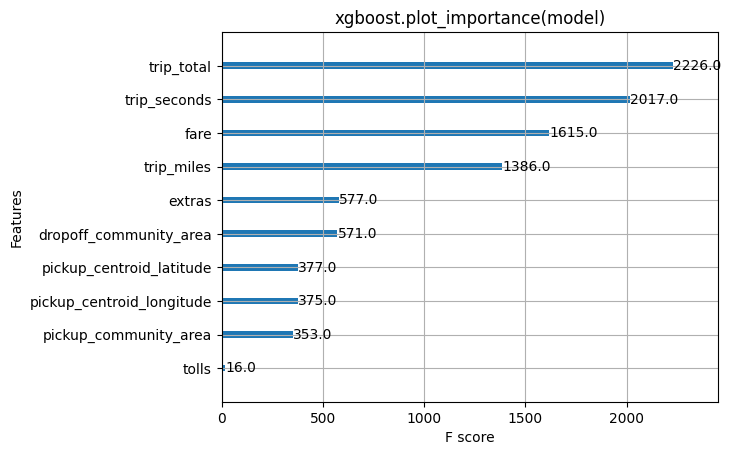

In [64]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

**Analyse the implications of all features**

### 1.2. Use shap tree explaner

In [65]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df.drop(['tips','trip_start_timestamp'],axis=1))

#### 1.2.1 See the average impact of each feature

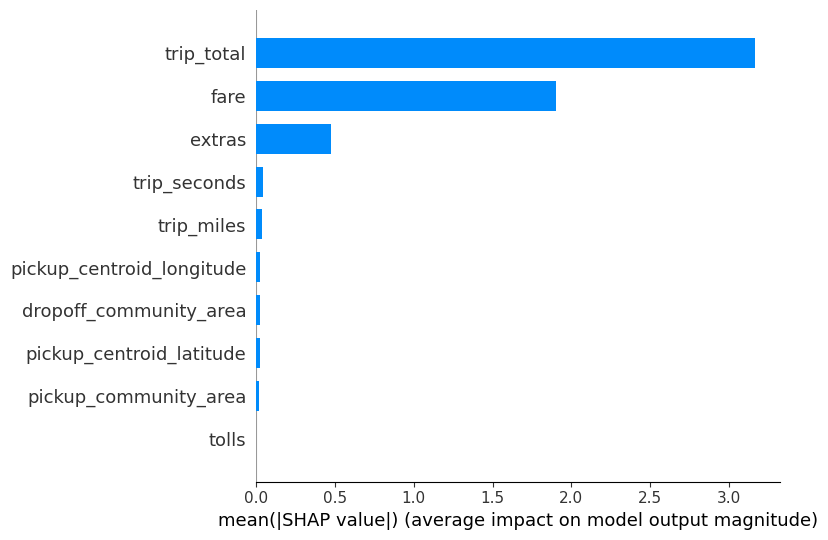

In [66]:
shap.summary_plot(shap_values, df.drop(['tips','trip_start_timestamp'],axis=1), plot_type="bar")


#### 1.2.2 see how the feature values impact the model output

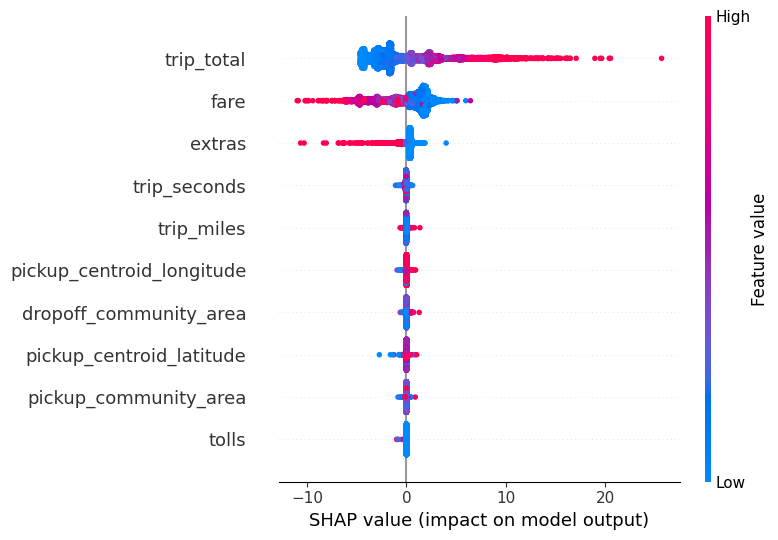

In [67]:
shap.summary_plot(shap_values, df.drop(['tips','trip_start_timestamp'],axis=1))

#### 1.2.3 evaluate your model 

In [68]:
predictions = model.predict(xgboost.DMatrix(X_test, label=y_test))

In [69]:

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 0.2353671434824717
Mean Squared Error: 0.8106344997889515
Root Mean Squared Error: 0.9003524308785708


## 2. Viewing all infos, optimize those metrics

In [57]:
model_opti  = xgboost_train(df[['trip_total','fare','extras','tips']],params,num_iterations=100)

[0]	test-rmse:2.65232
[1]	test-rmse:2.11024
[2]	test-rmse:1.74881
[3]	test-rmse:1.53149
[4]	test-rmse:1.35236
[5]	test-rmse:1.20995
[6]	test-rmse:1.13035
[7]	test-rmse:1.07843
[8]	test-rmse:1.05569
[9]	test-rmse:1.01582
[10]	test-rmse:0.98257
[11]	test-rmse:0.94686
[12]	test-rmse:0.93136
[13]	test-rmse:0.90690
[14]	test-rmse:0.89902
[15]	test-rmse:0.87966
[16]	test-rmse:0.86983
[17]	test-rmse:0.85636
[18]	test-rmse:0.84757
[19]	test-rmse:0.83218
[20]	test-rmse:0.82926
[21]	test-rmse:0.82290
[22]	test-rmse:0.81529
[23]	test-rmse:0.80806
[24]	test-rmse:0.80211
[25]	test-rmse:0.79889
[26]	test-rmse:0.79418
[27]	test-rmse:0.79174
[28]	test-rmse:0.78664
[29]	test-rmse:0.78296
[30]	test-rmse:0.78075
[31]	test-rmse:0.77864
[32]	test-rmse:0.77646
[33]	test-rmse:0.77553
[34]	test-rmse:0.77342
[35]	test-rmse:0.76982
[36]	test-rmse:0.76654
[37]	test-rmse:0.76555
[38]	test-rmse:0.76269
[39]	test-rmse:0.76038
[40]	test-rmse:0.75756
[41]	test-rmse:0.75689
[42]	test-rmse:0.75336
[43]	test-rmse:0.7516

In [58]:
explainer = shap.TreeExplainer(model_opti)
shap_values = explainer.shap_values(df[['trip_total','fare','extras']])

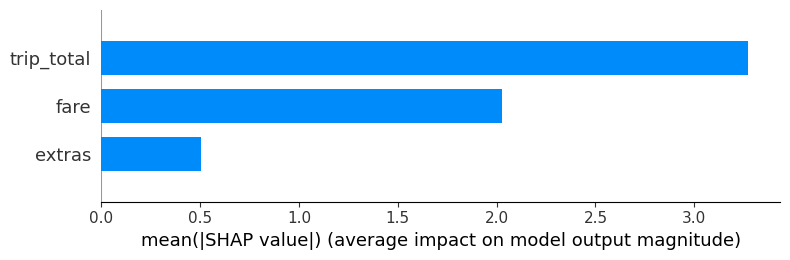

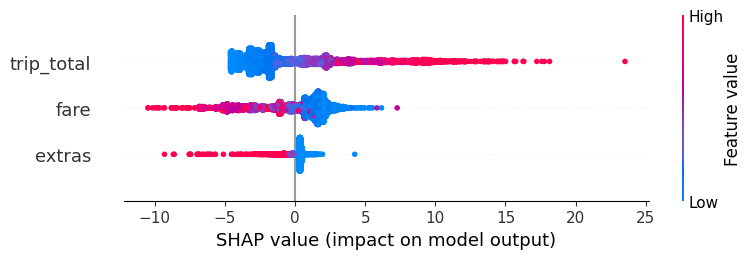

In [59]:
shap.summary_plot(shap_values, df[['trip_total','fare','extras']], plot_type="bar")
shap.summary_plot(shap_values, df[['trip_total','fare','extras']])

In [60]:
X_train2, X_test2, y_train2, y_test2 = create_sets(df[['trip_total','fare','extras','tips']])
predictions2 = model_opti.predict(xgboost.DMatrix(X_test2, label=y_test2))

In [61]:

# Calculate MAE
mae = mean_absolute_error(y_test2, predictions2)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test2, predictions2)
print('Mean Squared Error:', mse)

# Calculate RMSE
rmse = mean_squared_error(y_test2, predictions2, squared=False)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 0.1962645480504075
Mean Squared Error: 0.5254934097855875
Root Mean Squared Error: 0.7249092424473477


## 3. Using governance TP, log all of this in MLFLOW experiment to report the best options

In [ ]:
...